# Project 1 - Building an Agentic Corrective RAG System with LangGraph

This project will cover a full hands-on workflow and demonstration of how to build an Agentic Corrective RAG (CRAG) System with LangGraph

The idea would be to implement the workflow taking inspiration from the [Corrective Retrieval Augmented Generation](https://arxiv.org/pdf/2401.15884) research paper.

The main challenge of RAG systems include:

- Poor Retrieval can lead to issues in LLM response generation
- Bad retrieval or lack of information in the vector database can also lead to out of context or hallucinated answers

The idea is to couple a RAG system with a few checks in place and perform web searches if there is a lack of relevant context documents to the given user query as follows:

![](https://i.imgur.com/uhybMhT.png)


We can build this as an agentic RAG system by having a specific functionality step as a node in the graph and use LangGraph to implement it. Key steps in the node will include prompts being sent to LLMs to perform specific tasks as seen in the detailed workflow below:

![](https://i.imgur.com/eV87ZwX.gif)

## Install OpenAI, and LangChain dependencies

In [ ]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1
!pip install langchain-chroma==0.1.1

## Enter Open AI API Key

In [1]:
from getpass import getpass

## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [2]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

## Setup Environment Variables

In [3]:
import os

os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## Build a Search Index for Wikipedia Data

We will build a vector database for retrieval and search by taking a subset of documents from wikipedia, similar to our project from previous modules

### Ollama Embedding Models


In [28]:
from langchain_huggingface import HuggingFaceEmbeddings

embed_model =  HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

### Get the wikipedia data

In [ ]:
# if you can't download using the following code
# go to https://drive.google.com/file/d/1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW download it
# manually upload it on colab
!gdown 1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW

Downloading...
From (original): https://drive.google.com/uc?id=1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW
From (redirected): https://drive.google.com/uc?id=1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW&confirm=t&uuid=28e8b825-7880-4aea-98c9-ee3998c03545
To: /content/simplewiki-2020-11-01.jsonl.gz
100% 50.2M/50.2M [00:02<00:00, 18.6MB/s]


### Load and Chunk Documents

In [5]:
import gzip
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

wikipedia_filepath = 'data/simplewiki-2020-11-01.jsonl.gz'

docs = []
with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as fIn:
    for line in fIn:
        data = json.loads(line.strip())
        #Add all paragraphs
        #passages.extend(data['paragraphs'])
        #Only add the first paragraph
        docs.append({
                        'metadata': {
                                        'title': data.get('title'),
                                        'article_id': data.get('id')
                        },
                        'data': ' '.join(data.get('paragraphs')[0:3]) # restrict data to first 3 paragraphs to run later modules faster
        })

# We subset our data so we only use a subset of wikipedia documents to run things faster
docs = [doc for doc in docs for x in ['india']
              if x in doc['data'].lower().split()]
# Create docs
docs = [Document(page_content=doc['data'],
                 metadata=doc['metadata']) for doc in docs]
# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

In [6]:
len(chunked_docs)

1322

In [7]:
chunked_docs[:3]

[Document(metadata={'title': 'Basil', 'article_id': '73985'}, page_content='Basil ("Ocimum basilicum") ( or ) is a plant of the Family Lamiaceae. It is also known as Sweet Basil or Tulsi. It is a tender low-growing herb that is grown as a perennial in warm, tropical climates. Basil is originally native to India and other tropical regions of Asia. It has been cultivated there for more than 5,000 years. It is prominently featured in many cuisines throughout the world. Some of them are Italian, Thai, Vietnamese and Laotian cuisines. It grows to between 30–60\xa0cm tall. It has light green, silky leaves 3–5\xa0cm long and 1–3\xa0cm broad. The leaves are opposite each other. The flowers are quite big. They are white in color and arranged as a spike. The plant tastes somewhat like anise, with a strong, pungent, sweet smell. Basil is very sensitive to cold. It is best grown in hot, dry conditions. While most common varieties are treated as annuals, some are perennial, including African Blue a

### Create a Vector DB and persist on disk

Here we initialize a connection to a Chroma vector DB client, and also we want to save to disk, so we simply initialize the Chroma client and pass the directory where we want the data to be saved to.

In [29]:
from langchain.vectorstores import Qdrant
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

In [ ]:
# from langchain_community.vectorstores import Chroma

# # create vector DB of docs and embeddings - takes < 30s on Colab
# chroma_db = Chroma.from_documents(documents=chunked_docs,
#                                   collection_name='rag_wikipedia_db',
#                                   embedding=embed_model,
#                                   # need to set the distance function to cosine else it uses euclidean by default
#                                   # check https://docs.trychroma.com/guides#changing-the-distance-function
#                                   collection_metadata={"hnsw:space": "cosine"},
#                                   persist_directory="./wikipedia_db")

In [30]:
embed_dimension = len(embed_model.embed_query("test"))

In [31]:
embed_dimension

384

In [38]:
qdrant_client = QdrantClient(url="http://localhost:6333")

qdrant_client.recreate_collection(
    collection_name="rag_wikipedia_db",
    vectors_config=VectorParams(size=embed_dimension, distance=Distance.COSINE)
)

qdrant_db = Qdrant.from_documents(
    documents=chunked_docs,
    embedding=embed_model,
    url="http://localhost:6333",
    collection_name="rag_wikipedia_db",
    force_recreate=True
)

/tmp/ipykernel_6218/2303191431.py:3: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(


### Setup a Vector Database Retriever

Here we use the following retrieval strategy:

- Similarity with Threshold Retrieval


### Similarity with Threshold Retrieval

We use cosine similarity here and retrieve the top 3 similar documents based on the user input query and also introduce a cutoff to not return any documents which are below a certain similarity threshold

In [41]:
similarity_threshold_retriever = qdrant_db.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [42]:
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(metadata={'article_id': '731169', 'title': 'Central India', '_id': '336ded34-0d89-4bca-9006-5c1e43f32be1', '_collection_name': 'rag_wikipedia_db'}, page_content='Central India is an Indian region. Central India consists of two Indian states: Madhya Pradesh and Chhattisgarh. It shares a border with Rajasthan, Gujarat, Odisha, Jharkhand, Uttar Pradesh, Maharashtra and Telangana. Both the states are ruled by the Congress with Chief Ministers and This map of India (press to open) shows all central Indian states in the colour pink. The larger one is Madhya Pradesh while the smaller one is Chhattisgarh.'),
 Document(metadata={'article_id': '22215', 'title': 'States and union territories of India', '_id': '88ae912b-21f9-44ae-8f2a-034b1104cb07', '_collection_name': 'rag_wikipedia_db'}, page_content='The Republic of India is divided into twenty-eight States,and eight union territories including the National Capital Territory.'),
 Document(metadata={'article_id': '5117', 'title': 'New 

In [43]:
query = "what is langgraph?"
top3_docs = similarity_threshold_retriever.invoke(query)
top3_docs

[Document(metadata={'article_id': '774543', 'title': 'Indology', '_id': '99dcc7cd-c80c-45da-9d52-1b5773c5ef9a', '_collection_name': 'rag_wikipedia_db'}, page_content='Indology or Indian studies is the academic study of the history and cultures, languages, and literature of India and other Asian studies. There are two types of Indology, "Classical Indology" from "Modern Indology". Classical is about ancient India and Modern is about current-day India and its politics.'),
 Document(metadata={'article_id': '21589', 'title': 'Gujarati language', '_id': '687d0cbe-ea81-44ae-a64b-d35e81b2ef50', '_collection_name': 'rag_wikipedia_db'}, page_content='Gujarati is an Indo-Aryan language. It is spoken in Gujarat, India and also in neighbouring Pakistan. It was the "mother tongue" of Gandhi and Muhammad Ali Jinnah. There are millions of Gujaratis who speak it as their first language. Gujarati is the 20th most common language in the United States of America. Mahatma Gandhi, the India\'s leader, once

## Create a Query Retrieval Grader

Here we will use an LLM itself to grade if any retrieved document is relevant to the given question - Answer will be either `yes` or `no`

#### Try to use the VLLM to setup the Llama3 model 
- https://docs.vllm.ai/en/latest/getting_started/installation.html

In [56]:
from langchain_openai import ChatOpenAI

In [57]:
## Used VLLM to up the llama3 model along with api key and base url
llm = ChatOpenAI(model="llama3:8b-instruct-fp16", temperature=0, base_url="http://172.31.0.1:11434/v1", api_key="..")

In [50]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM for grading


# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
                  - Respond ONLY with 'yes' or 'no'.
             """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}

                     User question:
                     {question}

                     Is this document relevant? Respond with only 'yes' or 'no'.
                  """),
    ]
)

# Build grader chain
doc_grader = grade_prompt | llm

In [51]:
def grade_document(query, document):
    response = doc_grader.invoke({"question": query, "document": document})
    grade = response.content.strip().lower()
    if grade not in ['yes', 'no']:
        raise ValueError(f"Unexpected response from LLM: {grade}")
    return grade


In [52]:
# Example usage
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', grade_document(query, doc.page_content))
    print()

Central India is an Indian region. Central India consists of two Indian states: Madhya Pradesh and Chhattisgarh. It shares a border with Rajasthan, Gujarat, Odisha, Jharkhand, Uttar Pradesh, Maharashtra and Telangana. Both the states are ruled by the Congress with Chief Ministers and This map of India (press to open) shows all central Indian states in the colour pink. The larger one is Madhya Pradesh while the smaller one is Chhattisgarh.
GRADE: no

The Republic of India is divided into twenty-eight States,and eight union territories including the National Capital Territory.
GRADE: no

New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7 km. New Delhi has a population of about 9.4 Million people.
GRADE: yes



In [54]:
query = "what is langgraph?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', grade_document(query, doc.page_content))
    print()

Indology or Indian studies is the academic study of the history and cultures, languages, and literature of India and other Asian studies. There are two types of Indology, "Classical Indology" from "Modern Indology". Classical is about ancient India and Modern is about current-day India and its politics.
GRADE: no

Gujarati is an Indo-Aryan language. It is spoken in Gujarat, India and also in neighbouring Pakistan. It was the "mother tongue" of Gandhi and Muhammad Ali Jinnah. There are millions of Gujaratis who speak it as their first language. Gujarati is the 20th most common language in the United States of America. Mahatma Gandhi, the India's leader, once said about the Gujarati language: "Bad handwriting is a sign of an uncomplete education".
GRADE: no

Colors Tamil is an Tamil language pay television channel and satellite television channel. Owned and operated by Viacom 18, a media entertainment company based in Chennai, Tamil Nadu it broadcasts programming in Tamil language. The c

In [55]:
query = "who won the champions league in 2024?"
top3_docs = similarity_threshold_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', grade_document(query, doc.page_content))
    print()

The 2023 ICC Cricket World Cup is scheduled to be hosted by India and India was selected as the host at an International Cricket Council (ICC) meeting in London in June 2013. This will be the 13th Cricket World Cup competition. It will be the fourth time that India will be the host. This will be the first time that India has hosted the tournament on its own. India hosted previous World Cup tournaments in 1987 (with Pakistan), 1996 (with Pakistan and Sri Lanka) and 2011 (with Sri Lanka and Bangladesh). The semi final will be played at Wankhede Stadium. And final will be played at Eden Gardens, Kolkata. 5. ICC Cricket Worldcup 2023 Venue
GRADE: no

India national football team is the national football team of India. It has won the AFC challenge Cup in 2008 and ranks 150 in FIFA ranking (2014). The team is managed by Wim Koevermans. They have been runners up of Asian Nations Cup (1964). Their best result is to feature in the fourth olympic football tournament's finals in 1956.
GRADE: no



## Build a QA RAG Chain

We will now connect our retriever to an LLM and build our QA RAG Chain

In [58]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.

            Question:
            {question}

            Context:
            {context}

            Answer:
         """
prompt_template = ChatPromptTemplate.from_template(prompt)


# Used for separating context docs with new lines
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# create QA RAG chain
qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template
      |
    llm
      |
    StrOutputParser()
)

In [59]:
query = "what is the capital of India?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

The capital of India is New Delhi ().


In [60]:
query = "who won the champions league in 2024?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

I don't know the answer.

The provided context does not mention anything about the Champions League in 2024 or any other year. The context is primarily focused on cricket, football, and chess, with no information related to European football competitions like the Champions League. Therefore, I cannot provide an answer to this question based on the given context.


## Create a Query Rephraser

We will now build a query rephraser which will use an LLM to rephrase the input user query into a better version which is optimized for web search

In [61]:
# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}

                     Formulate an improved question.
                  """,
        ),
    ]
)
# Create rephraser chain
question_rewriter = (re_write_prompt
                        |
                       llm
                        |
                     StrOutputParser())

In [62]:
query = "who won the champions league in 2024?"
question_rewriter.invoke({"question": query})

'Here\'s a rewritten version of the question that\'s optimized for web search:\n\n"What was the winner of the UEFA Champions League tournament in the year 2024?"\n\nI made the following changes to improve the question:\n\n1. Added "UEFA" to specify which Champions League we\'re referring to, as there are multiple leagues with similar names.\n2. Changed "who won" to "what was the winner", which is a more precise and formal way of asking about the outcome of an event.\n3. Added "tournament" to provide more context and clarify that we\'re looking for information about the Champions League competition.\n\nThis rewritten question should yield better search results, as it\'s more specific and uses relevant keywords.'

## Load Web Search Tool

Here we will be using the [Tavily API](https://tavily.com/#api) for our web searches

In [63]:
from langchain_community.tools.tavily_search import TavilySearchResults

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

## Build Agentic RAG components

Here we will build the key components of our Agentic Corrective RAG System as per the workflow below:

![](https://i.imgur.com/uhybMhT.png)



### Graph State

Used to store and represent the state of the agent graph as we traverse through various nodes

In [64]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """

    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

### Retrieve function for retrieval from Vector DB

This will be used to get relevant context documents from the vector database

In [65]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]

    # Retrieval
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents, "question": question}

### Grade documents

This will be used to determine whether the retrieved documents are relevant to the question by using an LLM Grader

Sets the `web_search_needed` flag as `Yes` if at least one document is not contextually relevant and sets it as `No` if all documents are contextually relevant to the given user query

In [74]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.

    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search_needed = "No"
    if documents:
        for d in documents:
            try:
                grade = grade_document(question, d.page_content)
                if grade == "yes":
                    print("---GRADE: DOCUMENT RELEVANT---")
                    filtered_docs.append(d)
                else:
                    print("---GRADE: DOCUMENT NOT RELEVANT---")
                    web_search_needed = "Yes"
            except ValueError as e:
                print(f"Error grading document: {e}")
                web_search_needed = "Yes"
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"

    return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

### Rewrite query

This will be used to rewrite the input query to produce a better question optimized for web search using an LLM

In [67]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """

    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### Web Search

This will be used to search the web using the web search tool for the given query and retrieve some information which can be used as the context in RAG

In [78]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-written question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = tv_search.invoke(question)

    # Handle the case where docs is a string
    if isinstance(docs, str):
        web_results = docs
    else:
        # Assuming docs is a list of dictionaries or Document objects
        try:
            web_results = "\n\n".join([d.page_content if isinstance(d, Document) else d["content"] for d in docs])
        except (KeyError, TypeError):
            # If the above fails, join all string representations of the documents
            web_results = "\n\n".join([str(d) for d in docs])

    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

### Generate Answer

Standard LLM Response generation from query and context documents in a RAG system

In [69]:
def generate_answer(state):
    """
    Generate answer from context document using LLM

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

### Decide to Generate

This will be used as a conditional function which will check the `web_search_needed` flag and decide if a web search is needed or a response should be generated and return the function name to be called

In [70]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

### Build the Agent Graph

Here we will use LangGraph and build the agent as a graph

In [79]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer

# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()

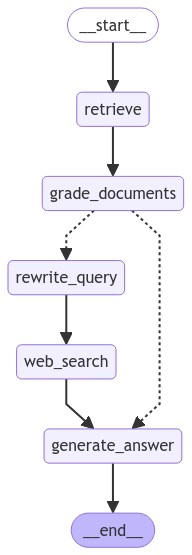

In [76]:
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

## Test the Agentic CRAG System

In [80]:
query = "what is the capital of India?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [ ]:
display(Markdown(response['generation']))

The capital city of India is New Delhi. It is a union territory within the larger metropolitan area of Delhi and is situated in the north-central part of the country on the west bank of the Yamuna River. New Delhi was formally dedicated as the capital in 1931 and has a population of about 9.4 million people.

In [ ]:
response

{'question': 'What is the capital city of India?',
 'generation': 'The capital city of India is New Delhi. It is a union territory within the larger metropolitan area of Delhi and is situated in the north-central part of the country on the west bank of the Yamuna River. New Delhi was formally dedicated as the capital in 1931 and has a population of about 9.4 million people.',
 'web_search_needed': 'Yes',
 'documents': [Document(page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.', metadata={'article_id': '5117', 'title': 'New Delhi'}),
  Document(page_content="Where is New Delhi?\nNew Delhi is situated in the north-central part of India on the west bank of the Yamuna River, adj

In [ ]:
query = "who won the champions league in 2024?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---


In [ ]:
display(Markdown(response['generation']))

The winner of the 2024 UEFA Champions League was Real Madrid. They secured victory in the final against Borussia Dortmund with goals from Dani Carvajal and Vinicius Junior.

In [ ]:
query = "Tell me about India"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [81]:
display(Markdown(response['generation']))

Based on the provided context, I can answer the question:

"What is the largest city and national capital of the Republic of India?"

The answer is: New Delhi. According to the context, New Delhi is not only the national capital of India but also a union territory of the megacity of Delhi. Additionally, it has a population of about 9.4 Million people, which suggests that it is indeed the largest city in terms of population.